### LLaVA use case demonstration

At that notebook you can see simple example of how to use TransformerLens for LLaVA interpretability. More specifically you can pass united image patch embeddings and textual embedding to LLaVA language model (Vicuna) with TransformerLens and get logits and cache that contains activations for next analysis. Here we consider the simplest example of LLaVA and TransformerLens sharing. 

In [1]:
# import staff
import sys

# Uncomment if use clonned version of TransformerLens
# currently forked version https://github.com/zazamrykh/TransformerLens supports
TL_path = r"../"
if TL_path not in sys.path:
	sys.path.insert(0, TL_path)
	sys.path.insert(0, TL_path + r"/transformer_lens")

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration   

# For image loading
from PIL import Image
import requests
from io import BytesIO


device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
%matplotlib inline

from transformer_lens import HookedTransformer
import circuitsvis as cv

_ = torch.set_grad_enabled(False)

Load llava model from hugging face. Load some revision because at this moment newest one is not working.

In [2]:
model_id = "llava-hf/llava-1.5-7b-hf"

llava = LlavaForConditionalGeneration.from_pretrained(
	model_id, 
	torch_dtype=torch.float16,
	load_in_4bit=False, 
	low_cpu_mem_usage=True,
	revision="a272c74",
	device_map="cpu"
)

for param in llava.parameters():  # At this demo we don't need grads
	param.requires_grad = False

processor = AutoProcessor.from_pretrained(model_id, revision="a272c74")
tokenizer = processor.tokenizer

# Taking model apart
language_model = llava.language_model.eval()
config = language_model.config
print("Base language model:", config._name_or_path)

vision_tower = llava.vision_tower.to(device).eval()
projector = llava.multi_modal_projector.to(device).eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Base language model: lmsys/vicuna-7b-v1.5


In [3]:
# You can write your own version of getting language model's input embeddings similar way
def get_llm_input_embeddings(llava, processor, image: Image, text: str, device='cuda'):
    """ Extract features from image, project them to LLM's space and insert them to text embedding sequence.  
    Returns: 
    	inputs_embeds, attention_mask, labels, position_ids - input for language model of LLaVA
    """
    conversation = [
      {
        "role": "user",
        "content": [
            {"type": "text", "text": text},
            {"type": "image"},
          ],
      },
    	]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(images=image, text=prompt, return_tensors='pt').to(device, torch.float16)    
    llava.vision_tower.to(device)
    llava.multi_modal_projector.to(device)
    
    clip_output = llava.vision_tower(inputs['pixel_values'])
    projector_output = llava.multi_modal_projector(clip_output.last_hidden_state)
	 
    before_device = llava.language_model.model.embed_tokens.weight.device
    llava.language_model.model.embed_tokens.to(device)
    text_embeddings = llava.language_model.model.embed_tokens(inputs['input_ids'])
    llava.language_model.model.embed_tokens.to(before_device)
    
    full_sequence = torch.hstack([projector_output, text_embeddings])

    attention_mask = torch.ones(full_sequence.shape[:-1], device=full_sequence.device, dtype=int)
    inputs_embeds, attention_mask, labels, position_ids = llava._merge_input_ids_with_image_features(
		projector_output, text_embeddings, inputs['input_ids'], attention_mask, labels=None
	)  # Access to private member... Well, but what can i do :-)
    
    return inputs_embeds, attention_mask, labels, position_ids

Okay, now create HookedTransformer model

In [4]:
hooked_llm = HookedTransformer.from_pretrained(
	"llama-7b-hf",  # Use config of llama
	center_unembed=False, 
	fold_ln=False, 
	fold_value_biases=False, 
	device='cuda', 
	hf_model=language_model,  # Use Vicuna's weights
	tokenizer=tokenizer, 
	center_writing_weights=False,
	dtype=torch.float16,
	vocab_size=language_model.config.vocab_size  # New argument. llama and vicuna have different vocab size, so we pass it here
)

for param in hooked_llm.parameters():
	param.requires_grad = False

Loaded pretrained model llama-7b-hf into HookedTransformer


Now try if hooked model is working

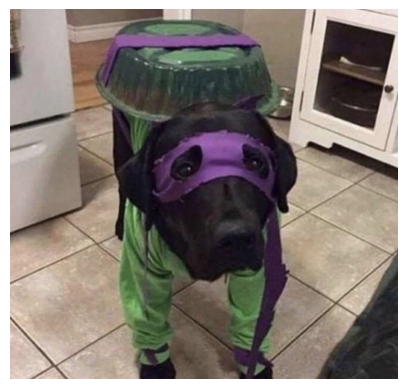

In [5]:
image_url = "https://github.com/zazamrykh/PicFinder/blob/main/images/doge.jpg?raw=true"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
plt.axis('off')
_ = plt.imshow(image)

In [9]:
question = "What do you see on photo?"
inputs_embeds, attention_mask, labels, position_ids = get_llm_input_embeddings(llava, processor, image, question, device=device)

# Return tokens 
outputs = hooked_llm.generate(
	inputs_embeds,
	max_new_tokens=30,
	do_sample=True,
    return_type='tokens'
)

generated_text = processor.decode(outputs, skip_special_tokens=True)
print('Generated text:', generated_text)

  0%|          | 0/30 [00:00<?, ?it/s]

Generated text: The image showcases a dog wearing a funny towel shaped like a giant plastic bottle cap. This witty towel


In [10]:
# Now return embeddings and then project them on vocab space
outputs = hooked_llm.generate(
	inputs_embeds,
	max_new_tokens=10,
	do_sample=True,
)

logits = outputs[:,-10:,:] @ language_model.model.embed_tokens.weight.T.to(device)
generated_text = processor.decode(logits.argmax(-1)[0], skip_special_tokens=True)
print('Generated text:', generated_text)

  0%|          | 0/10 [00:00<?, ?it/s]

Generated text: The image shows a person wearing a green sh


As we can see everything is working. Now try visualize attention patterns in generated output.

In [8]:
# Here we visualize attention for the last 30 tokens. 
logits, cache = hooked_llm.run_with_cache(inputs_embeds, start_at_layer=0, remove_batch_dim=True)

layer_to_visualize = 16
tokens_to_show = 30
attention_pattern = cache["pattern", layer_to_visualize, "attn"]

product = inputs_embeds @ language_model.model.embed_tokens.weight.T.to(device)  # Project embeddings to vocab
llama_str_tokens = hooked_llm.to_str_tokens(product.argmax(dim=-1)[0])

print(f"Layer {layer_to_visualize} Head Attention Patterns:")
display(cv.attention.attention_patterns(tokens=llama_str_tokens[-tokens_to_show:], 
										attention=attention_pattern[:, -tokens_to_show:, -tokens_to_show:]))

Layer 16 Head Attention Patterns:


As we can see image tokens also appears and can be used for multimodal attention exploration. 